In [1]:
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import column_or_1d

from keras.models import Sequential 
from keras.layers import Dense, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, RepeatVector 

In [2]:
# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('agr.csv')

In [3]:
# Xử lý dữ liệu
prices = data['Price']

In [4]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices.values.reshape(-1, 1))

In [5]:
scaled_prices

array([[0.15529524],
       [0.14823492],
       [0.14862937],
       ...,
       [0.54325843],
       [0.54525062],
       [0.54724281]])

In [6]:
#RATIO 82

In [7]:
# Chia dữ liệu thành tập train test
np.random.seed(42)

train_size = int(len(scaled_prices) * 0.8)
test_size = int(len(scaled_prices) * 0.2)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:train_size+test_size]

In [8]:
test_data

array([[0.22039206],
       [0.22745239],
       [0.22823333],
       [0.2356881 ],
       [0.24078413],
       [0.24705953],
       [0.2431389 ],
       [0.23725396],
       [0.21568651],
       [0.19490398],
       [0.18901905],
       [0.18901905],
       [0.20823572],
       [0.21176588],
       [0.21294127],
       [0.22392222],
       [0.22352777],
       [0.21098095],
       [0.19607937],
       [0.18509841],
       [0.19019444],
       [0.18862858],
       [0.16941191],
       [0.17019683],
       [0.15647064],
       [0.13960873],
       [0.15529524],
       [0.16941191],
       [0.17999841],
       [0.18156825],
       [0.18705873],
       [0.18235318],
       [0.17764762],
       [0.19607937],
       [0.21568651],
       [0.22745239],
       [0.23137302],
       [0.23294286],
       [0.25411587],
       [0.26862698],
       [0.24391983],
       [0.22156746],
       [0.24274444],
       [0.2431389 ],
       [0.23450873],
       [0.24901984],
       [0.24705953],
       [0.248

In [9]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)


In [10]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [11]:
X_train.shape

(1160, 30, 1)

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
# 8. Define GRU Model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='softmax'))
model.add(GRU(64, return_sequences = False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Đánh giá mô hình trên tập kiểm tra
loss = model.evaluate(X_test, y_test)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100

19/19 [==============================] - 2s 7ms/step - loss: 0.0728
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0530
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0291
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 9.3854e-04
Epoch 7/100
19/19 [==============================] - 0s 7ms/step - loss: 8.7544e-04
Epoch 8/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0010
Epoch 9/100
19/19 [==============================] - 0s 7ms/step - loss: 9.7483e-04
Epoch 10/100
19/19 [==============================] - 0s 7ms/step - loss: 8.2812e-04
Epoch 11/100
19/19 [==============================] - 0s 7ms/step - loss: 8.1776e-04
Epoch 12/100
19/19 [==============================] - 0s 7ms/step - loss: 8.1022e-04
Epoch 13/100

In [15]:
data.index


RangeIndex(start=0, stop=1488, step=1)

In [16]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Tạo biến train, test
train = prices[:train_size]
test = prices[train_size:train_size+test_size]

y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

n_past = 1
n_days_for_prediction= 30

#create an array of 30 integers starting from last index
predict_period_dates = np.array(range(len(data) + 1,len(data) + 31)).reshape(-1, 1)

print(predict_period_dates)

#Make prediction
prediction1 = model.predict(X_test[-n_days_for_prediction:])

prediction_copies1 = np.repeat(prediction1, prices.shape[0], axis=-1)
predicted_prices = scaler.inverse_transform(prediction_copies1)[:,0]
print(predicted_prices)

9/9 [==============================] - 0s 2ms/step
[[1489]
 [1490]
 [1491]
 [1492]
 [1493]
 [1494]
 [1495]
 [1496]
 [1497]
 [1498]
 [1499]
 [1500]
 [1501]
 [1502]
 [1503]
 [1504]
 [1505]
 [1506]
 [1507]
 [1508]
 [1509]
 [1510]
 [1511]
 [1512]
 [1513]
 [1514]
 [1515]
 [1516]
 [1517]
 [1518]]
1/1 [==============================] - 0s 16ms/step
[12627.279  13257.19   13598.5625 13665.503  14052.643  14709.4375
 15067.076  15049.42   15025.912  15072.709  15325.53   15319.864
 15398.746  15643.669  15913.634  15483.866  15290.668  15276.21
 15332.136  15517.25   15556.442  15609.473  16218.7    16746.254
 16969.465  16801.693  16405.664  16150.464  16036.211  15908.154 ]


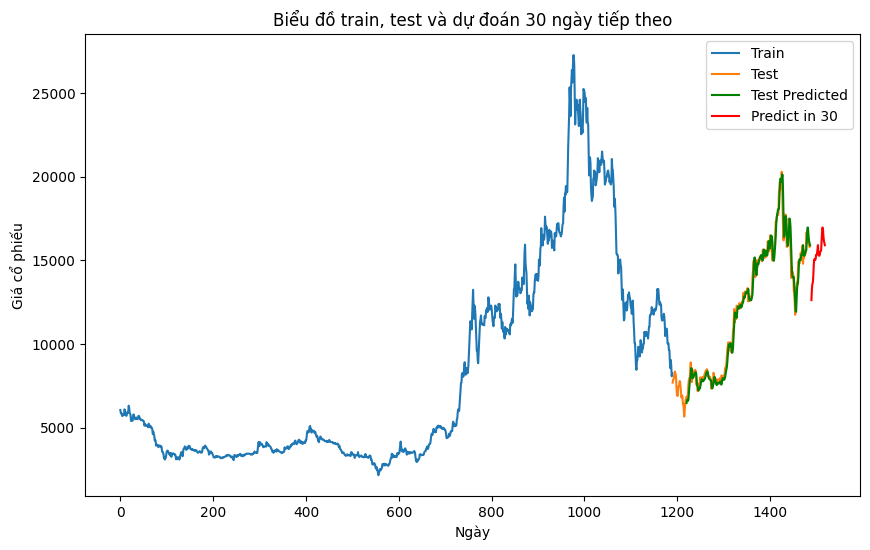

In [17]:
# Tạo biểu đồ train, test và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(range(train_size, train_size + len(test)), test, label='Test')

plt.plot(range(train_size + 30,train_size + test_size), y_test_pred, 'g', label='Test Predicted')

plt.plot(predict_period_dates, predicted_prices, 'r', label='Predict in 30')

plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.title('Biểu đồ train, test và dự đoán 30 ngày tiếp theo')
plt.legend()
plt.show()

In [18]:
y_test_pred

array([[ 6479.2114],
       [ 6639.626 ],
       [ 6674.7427],
       [ 6601.5   ],
       [ 6696.1006],
       [ 7050.9185],
       [ 7482.6284],
       [ 7785.344 ],
       [ 7924.4736],
       [ 8171.5737],
       [ 8555.24  ],
       [ 8562.116 ],
       [ 8130.337 ],
       [ 7951.793 ],
       [ 8031.3457],
       [ 8034.9556],
       [ 8114.749 ],
       [ 8216.976 ],
       [ 8272.44  ],
       [ 8298.197 ],
       [ 8327.794 ],
       [ 8177.8027],
       [ 7805.0806],
       [ 7523.0776],
       [ 7445.9956],
       [ 7272.1045],
       [ 7224.571 ],
       [ 7307.2983],
       [ 7358.807 ],
       [ 7355.647 ],
       [ 7545.2153],
       [ 7768.586 ],
       [ 7879.946 ],
       [ 7900.009 ],
       [ 7864.913 ],
       [ 7771.206 ],
       [ 7787.6123],
       [ 7841.8267],
       [ 7890.1094],
       [ 7896.6416],
       [ 7980.628 ],
       [ 8077.7583],
       [ 8186.404 ],
       [ 8285.831 ],
       [ 8344.704 ],
       [ 8377.392 ],
       [ 8273.965 ],
       [ 8095

In [19]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted, squared=False)

# Tính MSLE cho testing
msle_test = mean_squared_log_error(y_test1, y_test_predicted, squared=False)




9/9 [==============================] - 0s 3ms/step


In [20]:
y_test1

array([[ 6860.1],
       [ 6742. ],
       [ 6623.9],
       [ 7086.5],
       [ 7578.6],
       [ 7873.9],
       [ 7972.3],
       [ 8011.7],
       [ 8543.1],
       [ 8907.3],
       [ 8287.2],
       [ 7726.2],
       [ 8257.7],
       [ 8267.6],
       [ 8051. ],
       [ 8415.2],
       [ 8366. ],
       [ 8395.5],
       [ 8425. ],
       [ 8464.4],
       [ 8051. ],
       [ 7578.6],
       [ 7627.8],
       [ 7677. ],
       [ 7184.9],
       [ 7549.1],
       [ 7580. ],
       [ 7500. ],
       [ 7500. ],
       [ 8000. ],
       [ 8000. ],
       [ 8000. ],
       [ 8000. ],
       [ 7930. ],
       [ 7800. ],
       [ 8040. ],
       [ 7990. ],
       [ 8050. ],
       [ 8000. ],
       [ 8240. ],
       [ 8240. ],
       [ 8390. ],
       [ 8450. ],
       [ 8460. ],
       [ 8500. ],
       [ 8210. ],
       [ 8090. ],
       [ 8060. ],
       [ 8080. ],
       [ 7990. ],
       [ 8050. ],
       [ 8000. ],
       [ 7870. ],
       [ 7350. ],
       [ 7530. ],
       [ 7

In [21]:
mape_test *= 100


print('---------TEST----------')
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))
print("RMSE:", round(rmse_test,3))
print("MSLE:", round(msle_test,3))
print('-------------------')


---------TEST----------
MAPE: 2.996
MAE: 363.752
RMSE: 501.21
MSLE: 0.04
-------------------
